In [1]:
############ TO FIX / TO DO:

# OUTLIERS on ALL metrics, not just one column (input AND output)

# replace old outcomes dataframe in cleaning step with the new one in preprocessing step

# check alpha parameter

# **Data Source and Project Description**

Info goes here :) WIP

# **Initial Data Processing**

Citations:

**Importing Packages**

In [2]:
# basic libraries

import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
import warnings

# modeling libraries (some may not be needed, this is for initial testing)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, accuracy_score, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.linear_model import Lasso
from scipy import stats
from statsmodels.othermod.betareg import BetaModel, BetaResults
from statsmodels.genmod.families.links import identity
import patsy
from statsmodels.graphics.gofplots import qqplot
from scipy.stats.distributions import norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shap

In [41]:
# removing warnings for a cleaner markdown output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='shap')

**Importing Data**

Data source: XYZ

In [4]:
# allow access to Google Drive
# click "yes" on the account that has the data you want to import
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# importing data as a loop instead

transplant_data = pd.read_excel('/content/drive/MyDrive/Organ_Donation_and_Transplantation_Data.xlsx', sheet_name = None)
transplant_frames = {}
for key, value in transplant_data.items():
    strippedkey = key.replace(' ','').replace('-','_').lower()
    transplant_frames[strippedkey] = value

# access each df (example)
transplant_frames['otcoutcomemeasures']

HTTPError: HTTP Error 404: Not Found

**Cleaning Data**

In [6]:
# National Overview ############################################################
clean_overview = transplant_frames['overview_national'].copy()
clean_overview.isna().any()

# stripping the whitespace
clean_overview['Number of deceased organ donors recovered'] = clean_overview['Number of living organ donors recovered'].str.strip()
clean_overview['Number of living organ donors recovered'] = clean_overview['Number of living organ donors recovered'].str.strip()

# removing the . and suppressed values
clean_overview = clean_overview.replace({'.':np.nan, 'Suppressed':np.nan})

# dropping rows with missing values
clean_overview= clean_overview.dropna()

# converting columns to integer/datetime format/category
clean_overview = clean_overview.astype({'Number of deceased organ donors recovered':'int64',
                                        'Number of living organ donors recovered':'int64',
                                        'Number of living donor organ transplant recipients':'int64',
                                        'Organ': 'category',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]'})


# State Overview ###############################################################
clean_overview_state = transplant_frames['overview_state'].copy()
clean_overview_state.isna().any()
clean_overview_state = clean_overview_state.replace({'.':np.nan, 'Suppressed':np.nan})
clean_overview_state = clean_overview_state.dropna()

clean_overview_state = clean_overview_state.astype({'Year':'category',
                                        'State of Residence Name':'category',
                                        'State of Residence Code':'category',
                                        'Organ': 'category',
                                        'counts' : 'int64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]'})

# Donor Demographics ###########################################################
clean_demographics = transplant_frames['donordemographics'].copy()
# extracting first letter of category
clean_demographics['Category Code'] = clean_demographics['Category'].astype('str').str[0]
# removing '.' and suppressed
clean_demographics = clean_demographics.replace({'.': np.nan, 'Suppressed': np.nan})
clean_demographics = clean_demographics.dropna()
clean_demographics = clean_demographics.astype({'Category' : 'category',
                                                'Donor Type Filter' : 'category',
                                                'Level' : 'category',
                                                'Donor Count' : 'int64',
                                                'Last Refresh Date' : 'datetime64[ns]',
                                                'Date Range for Data - Start' : 'datetime64[ns]',
                                                'Date Range for Data - End' : 'datetime64[ns]',
                                                'Category Code' : 'category'})


# OPO - POTR ###################################################################
clean_opo = transplant_frames['opo_potr'].copy()
clean_opo['Procured Organ Transplant Rate'] = clean_opo['Procured Organ Transplant Rate'].astype('str').str.strip("%").str.strip()
clean_opo = clean_opo.replace({'.':np.nan, 'Suppressed':np.nan})
clean_opo = clean_opo.dropna()
clean_opo = clean_opo.astype({'OPO Name (State)' : 'category',
                                                'Year' : 'category',
                                                'Organ' : 'category',
                                                'Procured Organ Transplant Rate' : 'float64',
                                                'Last Refresh Date' : 'datetime64[ns]',
                                                'Date Range for Data - Start' : 'datetime64[ns]',
                                                'Date Range for Data - End' : 'datetime64[ns]'})

# OPO Service Area by County ###################################################
clean_service_area = transplant_frames['oposerviceareabycounty'].copy()
clean_service_area = clean_service_area.replace({'.':np.nan, 'Suppressed':np.nan})
clean_service_area  = clean_service_area.dropna()
#i moved the replace and drop up here
clean_service_area['State'] = clean_service_area['OPO Name (State)'].astype('str').str[-4:].str.strip('()')
clean_service_area['OPO'] = clean_service_area['OPO Name (State)'].astype('str').str[:-4]

# extract state last 2 letter code
clean_service_area['State'] = clean_service_area['OPO Name (State)'].astype(str).str[-3:-1]
#extract OPO from OPO Name everything before the last 4 characters
clean_service_area['OPO'] = clean_service_area['OPO Name (State)'].astype(str).str[:-4]
clean_service_area = clean_service_area.astype({'OPO Name (State)' : 'category',
                                                'County FIPS' : 'int64',
                                                'FIPS State Name' : 'category',
                                                'FIPS County Name' : 'category',
                                                'Service Area Overlap with' : 'category',
                                                'Last Refresh Date' : 'datetime64[ns]',
                                                'Date Range for Data - Start' : 'datetime64[ns]',
                                                'Date Range for Data - End' : 'datetime64[ns]',
                                                'State' : 'category',
                                                'OPO' : 'category'})


# Waitlist-Candidate Registration ##############################################
clean_waitcand = transplant_frames['waitlist_candidateregistration'].copy()
clean_waitcand = clean_waitcand.replace({'.':np.nan, 'Suppressed':np.nan})
clean_waitcand = clean_waitcand.dropna()
clean_waitcand = clean_waitcand.astype({'Candidate/Registration' : 'category',
                                        'Year of Addition' : 'category',
                                        'Organ Type' : 'category',
                                        'Total' : 'int64',
                                        'Sex: Female' : 'category',
                                        'Sex: Male' : 'category',
                                        'Race: White, Non-Hispanic' : 'int64',
                                        'Race: Black, Non-Hispanic' : 'int64',
                                        'Race: Asian, Non-Hispanic' : 'int64',
                                        'Race: Hispanic/Latino' : 'int64',
                                        'Race: Amer Ind/Alaska Native, Non-Hispanic' : 'int64',
                                        'Race: Native Hawaiian/other Pacific Islander, Non-Hispanic' : 'int64',
                                        'Race: Multiracial, Non-Hispanic' : 'int64',
                                        'Primary Payment: Medicare Advantage' : 'int64',
                                        'Primary Payment: Medicare FFS' : 'int64',
                                        'Primary Payment: Medicaid & CHIP' : 'int64',
                                        'Primary Payment: Other' : 'int64',
                                        'Primary Payment: Private' : 'int64',
                                        'Age Group: Pediatric' : 'int64',
                                        'Age Group: 18-30' : 'int64',
                                        'Age Group: 31-40' : 'int64',
                                        'Age Group: 41-50' : 'int64',
                                        'Age Group: 51-60' : 'int64',
                                        'Age Group: 61+' : 'int64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]'})

# Waitlist-OTC Transplant Rate #################################################
clean_waittransplant = transplant_frames['waitlist_otctransplantrate'].copy()
clean_waittransplant = clean_waittransplant.astype({'Percent of Deceased Donor Transplant with 1 Year' : 'str',
                                                   'Percent of Deceased Donor Transplant with 2 Years' : 'str',
                                                    'Percent of Deceased Donor Transplant with 30 Days' : 'str',
                                                    'Percent of Deceased Donor Transplant with 3 Years' : 'str'})

to_fix = clean_waittransplant[['Percent of Deceased Donor Transplant with 1 Year',
                               'Percent of Deceased Donor Transplant with 2 Years',
                               'Percent of Deceased Donor Transplant with 30 Days',
                               'Percent of Deceased Donor Transplant with 3 Years']]

clean_waittransplant[to_fix.columns] = to_fix.apply(lambda x: x.str.strip('%').str.strip())

clean_waittransplant['State'] = clean_waittransplant['Transplant Center (State)'].astype('str').str[-4:].str.strip('()')
clean_waittransplant['Transplant Center'] = clean_waittransplant['Transplant Center (State)'].astype('str').str[:-4]
clean_waittransplant = clean_waittransplant.replace({'.':np.nan, 'Suppressed':np.nan})
clean_waittransplant = clean_waittransplant.dropna()

clean_waittransplant = clean_waittransplant.astype({'Transplant Center (State)' : 'category',
                                        'Organ Type' : 'category',
                                        'Percent of Deceased Donor Transplant with 30 Days' : 'float64',
                                        'Percent of Deceased Donor Transplant with 1 Year' : 'float64',
                                        'Percent of Deceased Donor Transplant with 2 Years' : 'float64',
                                        'Percent of Deceased Donor Transplant with 3 Years' : 'float64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]',
                                        'State' : 'category',
                                        'Transplant Center' : 'category'})

# Waitlist-OTC Removal Reasons #################################################
clean_removal = transplant_frames['waitlist_otcremovalreasons'].copy()
clean_removal = clean_removal.replace({'.':np.nan, 'Suppressed':np.nan})
clean_removal = clean_removal .dropna()
clean_removal['State'] = clean_removal['Transplant Center (State)'].astype('str').str[-4:].str.strip('()')
clean_removal['Transplant Center'] = clean_removal['Transplant Center (State)'].astype('str').str[:-4]
clean_removal = clean_removal.astype({'Transplant Center (State)' : 'category',
                                        'Organ Type' : 'category',
                                        'Transferred to Another Center' : 'int64',
                                        'Received Living Donor Transplant' : 'int64',
                                        'Received Living Donor Transplant' : 'int64',
                                        'Died' : 'int64',
                                        'Received Transplant Elsewhere' : 'int64',
                                        'Too sick for Transplant' : 'int64',
                                        'Recovered without Transplant' : 'int64',
                                        'Other Reasons' : 'int64',
                                        'Last Refresh Date' : 'datetime64[ns]',
                                        'Date Range for Data - Start' : 'datetime64[ns]',
                                        'Date Range for Data - End' : 'datetime64[ns]',
                                        'State' : 'category',
                                        'Transplant Center' : 'category'})
#clean_removal.head()

# Recipient Demographics #######################################################
clean_recipient_demographics = transplant_frames['recipientdemographics'].copy()
clean_recipient_demographics = clean_recipient_demographics.replace({'.':np.nan, 'Suppressed':np.nan})
clean_recipient_demographics = clean_recipient_demographics.dropna()
clean_recipient_demographics = clean_recipient_demographics.astype({'Transplant Year' : 'category',
                                                                    'Donor Type' : 'category',
                                                                    'Organ Transplanted' : 'category',
                                                                    'Total Distinct Recipients' : 'int64',
                                                                    'Male Distinct Recipients' : 'int64',
                                                                    'Female Distinct Recipients' : 'int64',
                                                                    'Distinct Recipients with Age Not Reported' : 'int64',
                                                                    'Pediatric Distinct Recipients' : 'int64',
                                                                    'Age 18-30 Distinct Recipients' : 'int64',
                                                                    'Age 31-40 Distinct Recipients' : 'int64',
                                                                    'Age 41-50 Distinct Recipients' : 'int64',
                                                                    'Age 51-60 Distinct Recipients': 'int64',
                                                                    'Age 61+ Distinct Recipients' : 'int64',
                                                                    'White Distinct Recipients' : 'int64',
                                                                    'Black Distinct Recipients' : 'int64',
                                                                    'Hispanic Distinct Recipients' : 'int64',
                                                                    'Asian Distinct Recipients' : 'int64',
                                                                    'American Indian Distinct Recipients' : 'int64',
                                                                    'Native Hawaiian Distinct Recipients' : 'int64',
                                                                    'Multiracial Distinct Recipients' : 'int64',
                                                                    'Distinct Recipients with Medicare Advantage Payment Source' : 'int64',
                                                                    'Distinct Recipients with Private Insurance Payment Source' : 'int64',
                                                                    'Distinct Recipients with Medicare FFS Payment Source' : 'int64',
                                                                    'Distinct Recipients with Medicaid and CHIP Payment Source' : 'int64',
                                                                    'Distinct Recipients with Other Insurance Payment Sources' : 'int64',
                                                                    'Last Refresh Date' : 'datetime64[ns]',
                                                                    'Date Range for Data - Start' : 'datetime64[ns]',
                                                                    'Date Range for Data - End' : 'datetime64[ns]'})

# OTC Transplants by Demographics #######################################################
# this one has 'all centers' listed in it, so we must remove those columns first
clean_transplant_demographics = transplant_frames['otctransplantsbydemographics'].copy()
clean_transplant_demographics['OTC_Name_State'] = clean_transplant_demographics['OTC_Name_State'].astype('category')

demo_filter = clean_transplant_demographics['OTC_Name_State'].isin(['(All Centers)'])
clean_filtered_transplant_demographics = clean_transplant_demographics[~demo_filter]
demo_filter2 = clean_transplant_demographics[clean_transplant_demographics['OTC_Name_State'].isin(['(All Centers)'])]
demo_filter2['State'] = "None"
demo_filter2['OTC Name'] = "None"

clean_filtered_transplant_demographics['State'] = clean_filtered_transplant_demographics['OTC_Name_State'].astype('str').str[-4:].str.strip('()')
clean_filtered_transplant_demographics['OTC Name'] = clean_filtered_transplant_demographics['OTC_Name_State'].astype('str').str[:-4]

clean_filtered_transplant_demographics2 = pd.concat([clean_filtered_transplant_demographics, demo_filter2])
clean_filtered_transplant_demographics2 = clean_filtered_transplant_demographics2.replace({'.':np.nan, 'Suppressed':np.nan})
clean_filtered_transplant_demographics2 = clean_filtered_transplant_demographics2.dropna()

clean_filtered_transplant_demographics2 = clean_filtered_transplant_demographics2.astype({'OTC_Name_State' : 'category',
                                                                    'Donor Type' : 'category',
                                                                    'Organ Transplanted' : 'category',
                                                                    'Total Transplants' : 'int64',
                                                                    'Transplants with Male Recipients' : 'int64',
                                                                    'Transplants with Female Recipients' : 'int64',
                                                                    'Pediatric Transplants' : 'int64',
                                                                    'Transplants with Recipients Age 18-30' : 'int64',
                                                                    'Transplants with Recipients Age 31-40' : 'int64',
                                                                    'Transplants with Recipients Age 41-50' : 'int64',
                                                                    'Transplants with Recipients Age 51-60': 'int64',
                                                                    'Transplants with Recipients Age 61+' : 'int64',
                                                                    'Transplants with Recipients Age Not Reported' : 'int64',
                                                                    'White Recipient Transplants' : 'int64',
                                                                    'Black Recipient Transplants' : 'int64',
                                                                    'Hispanic Recipient Transplants' : 'int64',
                                                                    'Asian Recipient Transplants' : 'int64',
                                                                    'American Indian Recipient Transplants' : 'int64',
                                                                    'Native Hawaiian Recipient Transplants' : 'int64',
                                                                    'Multiracial Recipient Transplants' : 'int64',
                                                                    'Transplants with Private Insurance' : 'int64',
                                                                    'Transplants with Medicare FFS' : 'int64',
                                                                    'Transplants with Medicaid or CHIP' : 'int64',
                                                                                          'Transplants with Medicare Advantage' : 'int64',
                                                                                          'Transplants with Other Insurance Sources' : 'int64',
                                                                                          'Last Refresh Date' : 'datetime64[ns]',
                                                                    'Date Range for Data - Start' : 'datetime64[ns]',
                                                                    'Date Range for Data - End' : 'datetime64[ns]'})

# OTC Outcome Measures #########################################################
clean_outcomes = transplant_frames['otcoutcomemeasures'].copy()
clean_outcomes['State'] = clean_outcomes['OTC_Name_State'].astype('str').str[-4:].str.strip('()')

clean_outcomes['OTC Name'] = clean_outcomes['OTC_Name_State'].astype('str').str[:-4]

clean_outcomes[['Donor', 'Organ']] = clean_outcomes['Type'].str.split(' - ', expand=True)

to_fix2 = clean_outcomes[['Percent of Transplants with Functioning Graft at 30 Days',
                               'Percent of Transplants with Functioning Graft at 1 year',
                               'Percent of Patients Alive at 30 Days',
                               'Percent of Patients Alive at 1 Year']]

clean_outcomes = clean_outcomes.astype({'Percent of Transplants with Functioning Graft at 30 Days':'str',
                               'Percent of Transplants with Functioning Graft at 1 year':'str',
                               'Percent of Patients Alive at 30 Days':'str',
                               'Percent of Patients Alive at 1 Year':'str'

})

clean_outcomes = clean_outcomes.replace({'.':np.nan, 'Suppressed':np.nan})
clean_outcomes = clean_outcomes.dropna()

clean_outcomes['Percent of Transplants with Functioning Graft at 30 Days'] = clean_outcomes['Percent of Transplants with Functioning Graft at 30 Days'].str.strip('%').str.strip().astype('float64')

clean_outcomes['Percent of Transplants with Functioning Graft at 1 year'] = clean_outcomes['Percent of Transplants with Functioning Graft at 1 year'].str.strip('%').str.strip().astype('float64')

clean_outcomes['Percent of Patients Alive at 1 Year'] = clean_outcomes['Percent of Patients Alive at 1 Year'].str.strip('%').str.strip().astype('float64')

clean_outcomes['Percent of Patients Alive at 30 Days'] = clean_outcomes['Percent of Patients Alive at 30 Days'].str.strip('%').str.strip().astype('float64')

clean_outcomes

,OTC_Name_State,Type,Organ Transplanted,Percent of Transplants with Functioning Graft at 30 Days,Percent of Transplants with Functioning Graft at 1 year,Percent of Patients Alive at 30 Days,Percent of Patients Alive at 1 Year,Last Refresh Date,Date Range for Data - Start,Date Range for Data - End,State,OTC Name,Donor,Organ
0,Children's of Alabama (AL),Deceased Donor - Heart,Heart,100.00,100.00,100.00,100.00,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Deceased Donor,Heart
1,Children's of Alabama (AL),Deceased Donor - Kidney,Kidney,100.00,97.22,100.00,100.00,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Deceased Donor,Kidney
2,Children's of Alabama (AL),Deceased Donor - Liver,Liver,94.12,88.24,94.12,88.24,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Deceased Donor,Liver
3,Children's of Alabama (AL),Living Donor - Kidney,Kidney,100.00,100.00,100.00,100.00,"December 16, 2024","January 1, 2019","August 31, 2023",AL,Children's of Alabama,Living Donor,Kidney
4,University of Alabama Hospital (AL),Deceased Donor - Heart,Heart,98.04,91.09,99.02,91.09,"December 16, 2024","January 1, 2019","August 31, 2023",AL,University of Alabama Hospital,Deceased Donor,Heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,University of Wisconsin Hospital and Clinics (WI),Living Donor - Liver,Liver,100.00,87.50,100.00,87.50,"December 16, 2024","January 1, 2019","August 31, 2023",WI,University of Wisconsin Hospital and Clinics,Living Donor,Liver
1140,Charleston Area Medical Center (WV),Deceased Donor - Kidney,Kidney,97.07,88.58,97.56,90.82,"December 16, 2024","January 1, 2019","August 31, 2023",WV,Charleston Area Medical Center,Deceased Donor,Kidney
1141,Charleston Area Medical Center (WV),Living Donor - Kidney,Kidney,95.24,93.33,95.24,93.33,"December 16, 2024","January 1, 2019","August 31, 2023",WV,Charleston Area Medical Center,Living Donor,Kidney
1142,West Virginia University Hospitals Inc. (WV),Deceased Donor - Heart,Heart,100.00,96.88,100.00,96.88,"December 16, 2024","January 1, 2019","August 31, 2023",WV,West Virginia University Hospitals Inc.,Deceased Donor,Heart


**Merging Dataframes, Transformations, Mutates, etc.**

Gender Outcomes

In [7]:
# ID outliers
# Outliers for Alive at 30 Days
clean_outcomes_no_outliers = clean_outcomes.copy()
clean_outcomes_no_outliers[['Donor', 'Organ', 'OTC_Name_State']] = clean_outcomes_no_outliers[['Donor', 'Organ', 'OTC_Name_State']].astype('category')
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
    quantile1A30 = ('Percent of Patients Alive at 30 Days', lambda x: np.quantile(x,0.25)),
    quantile3A30 = ('Percent of Patients Alive at 30 Days', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
    IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
    upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
    lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers  = clean_outcomes_no_outliers.loc[
    (clean_outcomes_no_outliers['Percent of Patients Alive at 30 Days']<clean_outcomes_no_outliers['upcut']) &
    (clean_outcomes_no_outliers['Percent of Patients Alive at 30 Days']>clean_outcomes_no_outliers['lowcut'])]


clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]

# Alive at 1 Year
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
quantile1A30 = ('Percent of Patients Alive at 1 Year', lambda x: np.quantile(x,0.25)),
quantile3A30 = ('Percent of Patients Alive at 1 Year', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers = clean_outcomes_no_outliers.loc[
(clean_outcomes_no_outliers['Percent of Patients Alive at 1 Year']<clean_outcomes_no_outliers['upcut']) &
(clean_outcomes_no_outliers['Percent of Patients Alive at 1 Year']>clean_outcomes_no_outliers['lowcut'])]

clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]


# Functioning Graft at 30 Days
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
quantile1A30 = ('Percent of Transplants with Functioning Graft at 30 Days', lambda x: np.quantile(x,0.25)),
quantile3A30 = ('Percent of Transplants with Functioning Graft at 30 Days', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers = clean_outcomes_no_outliers.loc[
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 30 Days']<clean_outcomes_no_outliers['upcut']) &
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 30 Days']>clean_outcomes_no_outliers['lowcut'])]

clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]


# Functioning Graft at 30 Days
check = clean_outcomes_no_outliers.groupby(['Donor', 'Organ'], observed = True).agg(
quantile1A30 = ('Percent of Transplants with Functioning Graft at 1 year', lambda x: np.quantile(x,0.25)),
quantile3A30 = ('Percent of Transplants with Functioning Graft at 1 year', lambda x: np.quantile(x,0.75)),

).reset_index()

check = check.assign(
IQR = lambda x: x['quantile3A30'] - x['quantile1A30'],
upcut = lambda x: x['quantile3A30'] + (1.5 * x['IQR']),
lowcut = lambda x: x['quantile1A30'] - (1.5 * x['IQR']),
)

clean_outcomes_no_outliers = clean_outcomes_no_outliers.merge(check, on = ['Donor', 'Organ'])

# filter out the outliers
clean_outcomes_no_outliers = clean_outcomes_no_outliers.loc[
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 1 year']<clean_outcomes_no_outliers['upcut']) &
(clean_outcomes_no_outliers['Percent of Transplants with Functioning Graft at 1 year']>clean_outcomes_no_outliers['lowcut'])]


clean_outcomes_no_outliers = clean_outcomes_no_outliers[['OTC_Name_State',
'Organ',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year', 'Donor']]

clean_outcomes_no_outliers # 1015 rows

clean_outcomes_no_outliers = clean_outcomes_no_outliers.groupby(['OTC_Name_State', 'Organ', 'Donor'], observed=True).mean()

clean_outcomes_no_outliers = clean_outcomes_no_outliers.reset_index()

In [8]:
clean_transplant_demographics = transplant_frames['otctransplantsbydemographics'].copy()
clean_transplant_demographics['OTC_Name_State'] = clean_transplant_demographics['OTC_Name_State'].astype('category')

demo_filter = (clean_transplant_demographics['OTC_Name_State'] == '(All Centers)') | (clean_transplant_demographics['Donor Type'] == 'All Donors') | (clean_transplant_demographics['Organ Transplanted'] == 'All Transplanted Organ Types')
clean_transplant_demographics2 = clean_transplant_demographics[~demo_filter].reset_index(drop=True)
clean_transplant_demographics2[['OTC', 'State']] = clean_transplant_demographics2['OTC_Name_State'].str.split('(', expand=True)
clean_transplant_demographics2['State'] = clean_transplant_demographics2['State'].astype('str').str[-4:].str.strip('()')

clean_transplant_demographics3 = clean_transplant_demographics2.replace({'Suppressed':np.nan})

# make a specific subset instead
demo_subset1 = clean_transplant_demographics2[['OTC_Name_State', 'Donor Type',
                                               'Organ Transplanted',
                                               'Total Transplants',
                                               'Transplants with Female Recipients',
                                               'Transplants with Male Recipients',
                                               'OTC', 'State',
                                               'Transplants with Recipients Age 18-30',
                                               'Transplants with Recipients Age 31-40',
                                               'Transplants with Recipients Age 41-50',
                                               'Transplants with Recipients Age 51-60',
                                               'Transplants with Recipients Age 61+']]

demo_gender = demo_subset1.replace({'Suppressed':np.nan})
demo_gender = demo_gender.dropna()

demo_gender = demo_gender.astype({'OTC_Name_State' : 'category',
                                                'Donor Type' : 'category',
                                                'Organ Transplanted' : 'category',
                                                'Total Transplants' : 'int64',
                                                'Transplants with Female Recipients' : 'int64',
                                                'Transplants with Male Recipients' : 'int64',
                                                'OTC' : 'category',
                                  'State': 'category',
                                  'Transplants with Recipients Age 18-30' : 'int64',
                                  'Transplants with Recipients Age 31-40': 'int64',
                                  'Transplants with Recipients Age 41-50' : 'int64',
                                  'Transplants with Recipients Age 51-60' : 'int64',
                                  'Transplants with Recipients Age 61+' : 'int64'})

demo_gender = demo_gender.assign(
    FemaleTransplant = lambda x: x['Transplants with Female Recipients'] / x['Total Transplants'],
    MaleTransplant = lambda x: x['Transplants with Male Recipients'] / x['Total Transplants'],
    A18to30 = lambda x: x['Transplants with Recipients Age 18-30'] / x['Total Transplants'],
    A31to40 = lambda x: x['Transplants with Recipients Age 31-40'] / x['Total Transplants'],
    A41to50 = lambda x: x['Transplants with Recipients Age 41-50'] / x['Total Transplants'],
    A51to60 = lambda x: x['Transplants with Recipients Age 51-60'] / x['Total Transplants'],
    A61plus = lambda x: x['Transplants with Recipients Age 61+'] / x['Total Transplants']
)

demo_gender = demo_gender[['OTC_Name_State', 'Organ Transplanted', 'Donor Type', 'FemaleTransplant',
       'MaleTransplant', 'A18to30', 'A31to40', 'A41to50', 'A51to60',
       'A61plus', 'Total Transplants']]

demo_gender = demo_gender.groupby(['OTC_Name_State', 'Organ Transplanted', 'Donor Type'], observed=True).mean()

demo_gender = demo_gender.reset_index()

demo_gender = demo_gender.rename(columns={'Organ Transplanted':'Organ',
                                          'Donor Type':'Donor'})

In [9]:
# combining this subset with the other dataframe
outlier_subset1 = clean_outcomes_no_outliers[['OTC_Name_State',
                                              'Organ',
                                              'Donor',
       'Percent of Transplants with Functioning Graft at 30 Days',
       'Percent of Transplants with Functioning Graft at 1 year',
       'Percent of Patients Alive at 30 Days',
       'Percent of Patients Alive at 1 Year']]

outlier_subset1['Donor']= outlier_subset1['Donor'].astype('str').str.strip()

outlier_subset1['Donor']= outlier_subset1['Donor'].astype('category')

gender_outcomes = pd.merge(outlier_subset1, demo_gender, on = ['Organ', 'Donor', 'OTC_Name_State'], how='inner')

gender_outcomes.drop_duplicates()

,OTC_Name_State,Organ,Donor,Percent of Transplants with Functioning Graft at 30 Days,Percent of Transplants with Functioning Graft at 1 year,Percent of Patients Alive at 30 Days,Percent of Patients Alive at 1 Year,FemaleTransplant,MaleTransplant,A18to30,A31to40,A41to50,A51to60,A61plus,Total Transplants
0,AdventHealth Orlando (FL),Kidney,Deceased Donor,97.55,92.40,99.05,96.10,0.352657,0.647343,0.086957,0.164251,0.206119,0.264090,0.241546,621.0
1,AdventHealth Orlando (FL),Liver,Deceased Donor,97.19,91.11,98.23,92.48,0.392045,0.607955,0.059659,0.099432,0.127841,0.301136,0.264205,352.0
2,AdventHealth Porter (CO),Kidney,Living Donor,98.25,97.30,100.00,99.08,0.349398,0.650602,0.132530,0.108434,0.180723,0.198795,0.379518,166.0
3,Allegheny General Hospital (PA),Kidney,Deceased Donor,98.40,89.55,99.47,95.00,0.356984,0.643016,0.035477,0.090909,0.144124,0.215078,0.514412,451.0
4,Ann & Robert H. Lurie Children's Hospital of C...,Heart,Deceased Donor,99.18,92.86,99.18,92.86,0.414474,0.585526,0.111842,0.000000,0.000000,0.000000,0.000000,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Virtua Our Lady of Lourdes Hospital (NJ),Kidney,Deceased Donor,96.70,90.00,99.06,94.09,0.353147,0.646853,0.059441,0.125874,0.164336,0.328671,0.321678,286.0
216,Wake Forest Baptist Medical Center (NC),Kidney,Deceased Donor,97.98,90.83,99.66,94.23,0.490310,0.509690,0.052326,0.115310,0.190891,0.242248,0.380814,1032.0
217,Walter Reed National Military Medical Center a...,Kidney,Deceased Donor,100.00,96.85,100.00,99.19,0.375000,0.625000,0.102273,0.136364,0.130682,0.255682,0.375000,176.0
218,"Wellstar MCG Health, affiliated with Medical C...",Kidney,Deceased Donor,98.29,88.22,99.14,93.99,0.424444,0.575556,0.057778,0.113333,0.171111,0.271111,0.342222,450.0


Export the dataset if needed:

In [ ]:
from google.colab import files
gender_outcomes.to_csv('gender_outcomes_new2.csv', encoding = 'utf-8-sig')
files.download('gender_outcomes_new2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**EDA**

In [ ]:
# WIP

# **Beta Regression Model Testing**

##**Prechecking model variables using VIF**

In [10]:
# separate categorical vars and non-categorical vars first
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

#subset of columns from gender_outcome numericals
exog_vif = gender_outcomes[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Total Transplants','Percent of Transplants with Functioning Graft at 30 Days', 'Percent of Patients Alive at 30 Days']].reset_index(drop=True)

# new columns of proportions rather than raw % data
exog_vif = exog_vif.assign(
Graft30 = lambda x: x['Percent of Transplants with Functioning Graft at 30 Days'] / x['Total Transplants'],
Alive30 = lambda x: x['Percent of Patients Alive at 30 Days'] / x['Total Transplants'])

exog_vif = exog_vif[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Percent of Transplants with Functioning Graft at 30 Days', 'Percent of Patients Alive at 30 Days']].reset_index(drop=True)

#change categorical to numerical
exog_vif_dummy = pd.get_dummies(gender_outcomes, columns=['Organ', 'Donor'],
drop_first=False)

#chose specific categories
exog_vif_dummy = exog_vif_dummy[['Donor_Deceased Donor',
'Organ_Kidney','Organ_Liver','Organ_Heart']].reset_index(drop=True)

#1 for true 0 for false
exog_vif_dummy = exog_vif_dummy.replace({True:1, False:0})
exog_vif_dummy = pd.DataFrame(exog_vif_dummy)

#combines the changed variables from categorical to numeric with the numerica from original df
exog_vif_final = pd.concat([exog_vif_dummy.reset_index(drop=True), exog_vif.reset_index(drop=True)], axis=1)

# perform VIF
print("these are VIF values: > 5 consider dropping, >10 should drop")
print(round(variance_inflation_factor(exog_vif_final, 0),2), exog_vif_final.columns[0])
print(round(variance_inflation_factor(exog_vif_final, 1),2), exog_vif_final.columns[1])
print(round(variance_inflation_factor(exog_vif_final, 2),2), exog_vif_final.columns[2])
print(round(variance_inflation_factor(exog_vif_final, 3),2), exog_vif_final.columns[3])
print(round(variance_inflation_factor(exog_vif_final, 4),2), exog_vif_final.columns[4])
print(round(variance_inflation_factor(exog_vif_final, 5),2), exog_vif_final.columns[5])
print(round(variance_inflation_factor(exog_vif_final, 6),2), exog_vif_final.columns[6])
print(round(variance_inflation_factor(exog_vif_final, 7),2), exog_vif_final.columns[7])
print(round(variance_inflation_factor(exog_vif_final, 9),2), exog_vif_final.columns[9])
print(round(variance_inflation_factor(exog_vif_final, 10),2), exog_vif_final.columns[10])
print(round(variance_inflation_factor(exog_vif_final, 11),2), exog_vif_final.columns[11])

these are VIF values: > 5 consider dropping, >10 should drop
9.68 Donor_Deceased Donor
42.36 Organ_Kidney
12.87 Organ_Liver
9.3 Organ_Heart
145.75 FemaleTransplant
13.04 A18to30
24.83 A31to40
54.71 A41to50
31.55 A61plus
26943.02 Percent of Transplants with Functioning Graft at 30 Days
28632.66 Percent of Patients Alive at 30 Days


##**Splitting into the testing and training sets**

In [11]:
# split the set ################################################################

# set X and y
y = gender_outcomes[[
'Percent of Transplants with Functioning Graft at 1 year',
'Percent of Patients Alive at 1 Year', 'Total Transplants']]

# rename columns in y to make the labels fit with the formula creator
X = gender_outcomes[['Donor', 'Organ',
'FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Percent of Transplants with Functioning Graft at 30 Days',
'Percent of Patients Alive at 30 Days', 'Total Transplants']]

# here is where the new transformation goes:
X = X.assign(
Graft30DaysPerc = lambda x: x['Percent of Transplants with Functioning Graft at 30 Days']/100,
Alive30DaysPerc = lambda x: x['Percent of Patients Alive at 30 Days']/100,
Graft30Days = lambda x: (
(x['Graft30DaysPerc']*(
x['Graft30DaysPerc'].count()-1) + 0.5
) / x['Graft30DaysPerc'].count()),
Alive30Days = lambda x: (
(x['Alive30DaysPerc']*(
x['Alive30DaysPerc'].count()-1) +0.5
) / x['Alive30DaysPerc'].count()),
A18to30 = lambda x: (
(x['A18to30']*(
x['A18to30'].count()-1) +0.5
) / x['A18to30'].count()),
A31to40 = lambda x: (
(x['A31to40']*(
x['A31to40'].count()-1) +0.5
) / x['A31to40'].count()),
A41to50 = lambda x: (
(x['A41to50']*(
x['A41to50'].count()-1) +0.5
) / x['A41to50'].count()),
A51to60 = lambda x: (
(x['A51to60']*(
x['A51to60'].count()-1) +0.5
) / x['A51to60'].count()),
A61plus= lambda x: (
(x['A61plus']*(
x['A61plus'].count()-1) +0.5
) / x['A61plus'].count())
)
y = y.assign(
Graft1YearPerc = lambda x: x['Percent of Transplants with Functioning Graft at 1 year']/100,
Alive1YearPerc = lambda x: x['Percent of Patients Alive at 1 Year']/100,
Graft1Year = lambda x: (
(x['Graft1YearPerc']*(
x['Graft1YearPerc'].count()-1) + 0.5
) / x['Graft1YearPerc'].count()),
Alive1Year = lambda x: (
(x['Alive1YearPerc']*(
x['Alive1YearPerc'].count()-1) + 0.5
) / x['Alive1YearPerc'].count())
)

y = y[['Graft1Year',
'Alive1Year']]

X = X[['Donor', 'Organ',
'FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=424)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# scaling data
scaler = StandardScaler()
# use fit_transform for the training set (fit = teach the scaler how to scale it, transform = scale it)
X_train_scaled_subset = X_train[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]
X_train_scaled_subset = scaler.fit_transform(X_train_scaled_subset)
X_train_scaled_subset = pd.DataFrame(X_train_scaled_subset, columns = X_train[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].columns)

X_train_categorical_vars = X_train[['Donor', 'Organ']].reset_index(drop=True)
X_train = pd.concat([X_train_categorical_vars, X_train_scaled_subset], axis=1)

# use transform just transform (the already established transformation from previous step) on test set
X_test_scaled_subset = X_test[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]
X_test_scaled_subset = scaler.transform(X_test_scaled_subset)
X_test_scaled_subset = pd.DataFrame(X_test_scaled_subset, columns = X_test[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].columns)

X_test_categorical_vars = X_test[['Donor', 'Organ']].reset_index(drop=True)

X_test = pd.concat([X_test_categorical_vars, X_test_scaled_subset], axis=1)

X_train_scaled = pd.DataFrame(X_train)
X_test_scaled = pd.DataFrame(X_test)

train_frame = pd.concat([X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_frame = pd.concat([X_test_scaled.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

##**Performing Lasso Regresion for variable reduction**

In [12]:
# lasso regression #############################################################
endog_array = y_train['Alive1Year'].values
endog_array2 = y_test['Alive1Year'].values

exog_array = X_train.values
# convert these to dummy variables
non_exog_dummy = X_train_scaled[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy = pd.get_dummies(X_train_scaled, columns=['Donor', 'Organ'],drop_first=False)
# remove alive donor because of 1:1 collinearity
exog_dummy = exog_dummy[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy = exog_dummy.replace({True:1, False:0})
exog_dummy = pd.DataFrame(exog_dummy)
exog_dummy = pd.concat([exog_dummy.reset_index(drop=True), non_exog_dummy.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy = sm.add_constant(exog_dummy)
exog_dummy = exog_dummy.values

# convert these to dummy variables
non_exog_dummy2 = X_test_scaled[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy2 = pd.get_dummies(X_test_scaled, columns=['Donor', 'Organ'],drop_first=False)
exog_dummy2 = exog_dummy2[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy2 = exog_dummy2.replace({True:1, False:0})
exog_dummy2 = pd.DataFrame(exog_dummy2)
exog_dummy2 = pd.concat([exog_dummy2.reset_index(drop=True), non_exog_dummy2.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy2 = sm.add_constant(exog_dummy2)
exog_dummy2 = exog_dummy2.values

lasso_original = OLS(endog_array, exog_dummy).fit_regularized(method='elastic_net', L1_wt=1.0) # not sure about the alpha param here...

params = pd.DataFrame(lasso_original.params)
params['Column'] = ['const','Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung','FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']
params['Parameters'] = params[0]
params = params[['Column', 'Parameters']]

# removing lowest variables
# keep the ones furthest from zero, negatives are OK!
params = params.assign(
Parameters = lambda x: np.absolute(x['Parameters'])
)
params.sort_values(by='Parameters', ascending=False, inplace=True)
print(params)

# create a filter threshold
param_filter = (params['Parameters'] > 0.015) # arbitrary; change to something else later?
params2 = params.loc[param_filter]
use_these_variables = list(params2['Column'])
print("Use these variables:", use_these_variables)

# applying the filter ##########################################################
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

exog_array = X_train.values
# convert these to dummy variables
non_exog_dummy = X_train_scaled[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy = pd.get_dummies(X_train_scaled, columns=['Donor', 'Organ'],drop_first=False)
# remove alive donor because of 1:1 collinearity
exog_dummy = exog_dummy[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy = exog_dummy.replace({True:1, False:0})
exog_dummy = pd.DataFrame(exog_dummy)
exog_dummy = pd.concat([exog_dummy.reset_index(drop=True), non_exog_dummy.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy = sm.add_constant(exog_dummy)
exog_dummy = exog_dummy[use_these_variables]
exog_dummy = exog_dummy.values

# convert these to dummy variables
non_exog_dummy2 = X_test_scaled[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].reset_index(drop=True)
exog_dummy2 = pd.get_dummies(X_test_scaled, columns=['Donor', 'Organ'],drop_first=False)
exog_dummy2 = exog_dummy2[['Donor_Deceased Donor',
'Organ_Liver',
'Organ_Heart',
'Organ_Kidney',
'Organ_Lung']].reset_index(drop=True)
exog_dummy2 = exog_dummy2.replace({True:1, False:0})
exog_dummy2 = pd.DataFrame(exog_dummy2)
exog_dummy2 = pd.concat([exog_dummy2.reset_index(drop=True), non_exog_dummy2.reset_index(drop=True)], axis=1)

# add a constant
exog_dummy2 = sm.add_constant(exog_dummy2)
exog_dummy2 = exog_dummy2[use_these_variables]
exog_dummy2 = exog_dummy2.values

endog_array = y_train['Alive1Year'].values
endog_array2 = y_test['Alive1Year'].values

                  Column  Parameters
0                  const    0.948230
5             Organ_Lung    0.030077
13           Alive30Days    0.018815
1   Donor_Deceased Donor    0.018686
4           Organ_Kidney    0.017629
2            Organ_Liver    0.015146
3            Organ_Heart    0.011279
11               A61plus    0.003577
9                A41to50    0.003320
8                A31to40    0.002481
12           Graft30Days    0.002208
10               A51to60    0.000716
6       FemaleTransplant    0.000495
7                A18to30    0.000484
Use these variables: ['const', 'Organ_Lung', 'Alive30Days', 'Donor_Deceased Donor', 'Organ_Kidney', 'Organ_Liver']


##**Doing a second VIF test to check for multicollinearity issues on trimmed variables**


In [13]:
exog_vif2 = gender_outcomes[['Percent of Patients Alive at 30 Days', 'Total Transplants']].reset_index(drop=True)

# new columns of proportions rather than raw % data
exog_vif2['Alive30'] = exog_vif2['Percent of Patients Alive at 30 Days'] / exog_vif2['Total Transplants']

exog_vif2 = exog_vif2['Alive30'].reset_index(drop=True)

# change categorical to numerical
exog_vif2_dummy = pd.get_dummies(gender_outcomes, columns=['Organ', 'Donor'],
drop_first=False)

# choose specific categories
exog_vif2_dummy = exog_vif2_dummy[['Donor_Deceased Donor',
'Organ_Kidney','Organ_Liver', 'Organ_Lung']].reset_index(drop=True)

# 1 for true 0 for false
exog_vif2_dummy = exog_vif2_dummy.replace({True:1, False:0})
exog_vif2_dummy = pd.DataFrame(exog_vif2_dummy)

# combines the changed variables from categorical to numeric with the numeric from original df
exog_vif2_final = pd.concat([exog_vif2_dummy.reset_index(drop=True), exog_vif2.reset_index(drop=True)], axis=1)

# perform VIF
print("these are VIF values for the second round: > 5 consider dropping, >10 should drop")

print(round(variance_inflation_factor(exog_vif2_final, 0),2), exog_vif2_final.columns[0])
print(round(variance_inflation_factor(exog_vif2_final, 1),2), exog_vif2_final.columns[1])
print(round(variance_inflation_factor(exog_vif2_final, 2),2), exog_vif2_final.columns[2])
print(round(variance_inflation_factor(exog_vif2_final, 3),2), exog_vif2_final.columns[3])
print(round(variance_inflation_factor(exog_vif2_final, 4),2), exog_vif2_final.columns[4])

these are VIF values for the second round: > 5 consider dropping, >10 should drop
3.42 Donor_Deceased Donor
2.66 Organ_Kidney
1.8 Organ_Liver
1.11 Organ_Lung
1.88 Alive30


##**The finalized Beta Regression model!**

In [14]:
# beta regression ##############################################################

gender_model_final = BetaModel(endog_array, exog_dummy)
result_gender_final = gender_model_final.fit()
print(result_gender_final.summary(yname = 'Alive1Year',
xname = ['Constant',
'Organ_Lung',
'Alive30Days',
'Donor_Deceased Donor',
'Organ_Kidney',
'Organ_Liver', 'precision'],
title = 'Beta Regression Model Results: Proportion of Patients Alive At 1 Year After Transplant Surgery'))
y_pred = result_gender_final.predict(exog_dummy2)
mse = mean_squared_error(endog_array2, y_pred)

# checking model accuracy using Mean Squared Error
print(mse) # look for low MSE

Beta Regression Model Results: Proportion of Patients Alive At 1 Year After Transplant Surgery
Dep. Variable:             Alive1Year   Log-Likelihood:                 447.98
Model:                      BetaModel   AIC:                            -882.0
Method:            Maximum Likelihood   BIC:                            -860.2
Date:                Fri, 21 Mar 2025                                         
Time:                        02:48:52                                         
No. Observations:                 165                                         
Df Residuals:                     158                                         
Df Model:                           5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Constant                 3.9619      0.154     25.766      0.000       3.661       4.263
Organ_

# **Keras Deep Learning Neural Network Model**

##**A Survival Rate Expectancy Training and Testing Set**

In [15]:
# using the previously established X and y dataframes created before performing the beta regression

y = y[['Graft1Year',
'Alive1Year']]

X = X[['Donor', 'Organ',
'FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=424)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# scaling data
scaler = StandardScaler()
# use fit_transform for the training set (fit = teach the scaler how to scale it, transform = scale it)
X_train_scaled_subset = X_train[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]
X_train_scaled_subset = scaler.fit_transform(X_train_scaled_subset)
X_train_scaled_subset = pd.DataFrame(X_train_scaled_subset, columns = X_train[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].columns)

X_train_categorical_vars = X_train[['Donor', 'Organ']].reset_index(drop=True)
X_train = pd.concat([X_train_categorical_vars, X_train_scaled_subset], axis=1)

# use transform just transform (the already established transformation from previous step) on test set
X_test_scaled_subset = X_test[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]
X_test_scaled_subset = scaler.transform(X_test_scaled_subset)
X_test_scaled_subset = pd.DataFrame(X_test_scaled_subset, columns = X_test[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']].columns)

X_test_categorical_vars = X_test[['Donor', 'Organ']].reset_index(drop=True)

X_test = pd.concat([X_test_categorical_vars, X_test_scaled_subset], axis=1)

X_train_scaled = pd.DataFrame(X_train)
X_test_scaled = pd.DataFrame(X_test)

# we now have X_train and X_test features with y_train and y_test separated
print(X_train_scaled)

              Donor   Organ  FemaleTransplant   A18to30   A31to40   A41to50  \
0    Deceased Donor  Kidney          0.248892 -0.665947 -0.362429 -0.399834   
1    Deceased Donor   Heart         -1.229202 -0.139325 -0.427064 -1.346261   
2    Deceased Donor   Heart         -1.083726 -0.207049 -1.299278 -1.913810   
3    Deceased Donor  Kidney         -0.338406 -0.821634 -1.259662 -0.224288   
4    Deceased Donor  Kidney          0.633389 -0.184964  0.128519  0.017833   
..              ...     ...               ...       ...       ...       ...   
160  Deceased Donor   Liver          4.085590 -2.019668 -2.811462 -3.829852   
161  Deceased Donor  Kidney          0.221370  0.336976  1.600137  0.336459   
162  Deceased Donor    Lung          0.828732 -0.372099 -1.371519 -2.439751   
163  Deceased Donor  Kidney          0.370154 -0.048363  1.012160  1.210916   
164  Deceased Donor  Kidney         -0.635615 -0.396788  0.055608 -0.216298   

      A51to60   A61plus  Graft30Days  Alive30Days  

###**Creating dummy variables on separate train/test sets**

In [16]:

# X_train
# change categorical to numeric
dummy_X_train = pd.get_dummies(X_train_scaled, columns=['Organ', 'Donor'],
drop_first=False)
dummy_X_train_num = X_train_scaled[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]

#1 for true 0 for false
dummy_X_train = dummy_X_train.replace({True:1, False:0})
dummy_X_train = pd.DataFrame(dummy_X_train)

# X_test
# change categorical to numeric
dummy_X_test = pd.get_dummies(X_test_scaled, columns=['Organ', 'Donor'],
drop_first=False)
dummy_X_test_num = X_test_scaled[['FemaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Graft30Days',
'Alive30Days']]

#1 for true 0 for false
dummy_X_test = dummy_X_test.replace({True:1, False:0})
dummy_X_test = pd.DataFrame(dummy_X_test)

# create y_variables for 1-year survival only
dummy_y_train = y_train['Alive1Year']
dummy_y_test = y_test['Alive1Year']

###**Performing the Test**

In [20]:
keras.utils.set_random_seed(812)
# creating the model
model = Sequential()

# hidden layers
model.add(Dense(64, input_shape=(14,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# output layers
model.add(Dense(1, activation='sigmoid')) # since our y is bounded between 0 and 1

# compile model
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

# creating early stops and model saves
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_save = ModelCheckpoint('best_regression_model.keras', save_best_only=True)

# Fit your model
model.fit(dummy_X_train, dummy_y_train,
                    epochs = 100,
                    callbacks = [early_stop, model_save],
                    validation_data = (dummy_X_test, dummy_y_test))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.1242 - val_mean_squared_error: 0.1242
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.0661 - val_mean_squared_error: 0.0661
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0027 - val_mean_squared

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,037 (109.52 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,692 (73.02 KB)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [38]:
samples_test = shap.sample(dummy_X_test, 20)
samples_train = shap.sample(dummy_X_train, 20)
explainer = shap.Explainer(model, samples_train)
shap_values = explainer(samples_test)

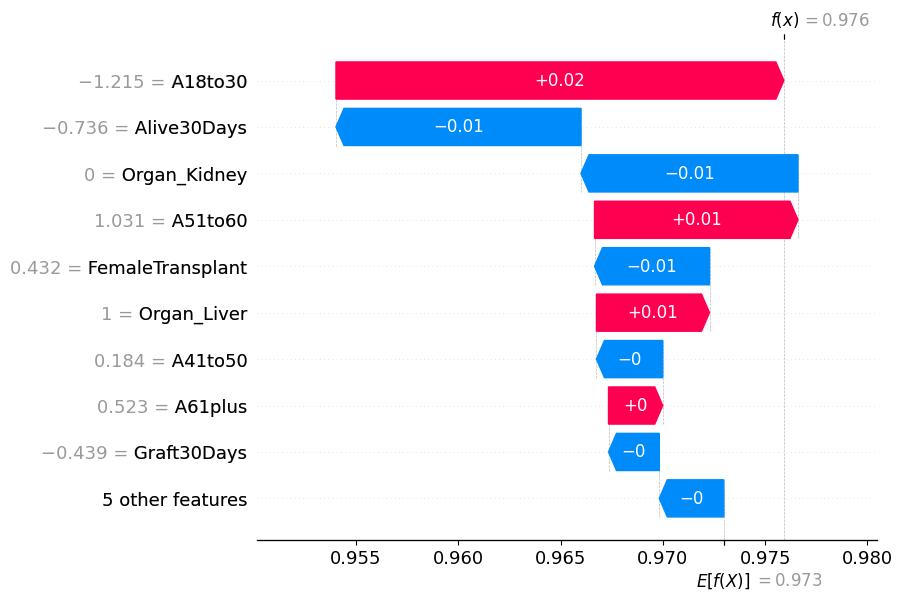

In [37]:
shap.plots.waterfall(shap_values[0])

##**An Organ Classification Training and Testing Set**

###**Creating one-hot endoded outputs instead for an organ classification problem:**

In [ ]:

# using the previously established X and y dataframes created before performing the beta regression

# set X and y
y = gender_outcomes[['Donor', 'Organ']]

# rename columns in y to make the labels fit with the formula creator
X = gender_outcomes[['Percent of Transplants with Functioning Graft at 1 year',
'Percent of Patients Alive at 1 Year', 'Total Transplants',
'FemaleTransplant','MaleTransplant',
'A18to30', 'A31to40', 'A41to50', 'A51to60',
'A61plus', 'Percent of Transplants with Functioning Graft at 30 Days',
'Percent of Patients Alive at 30 Days', 'Total Transplants']]

# here is where the new transformation goes:
X = X.assign(
Graft30DaysPerc = lambda x: x['Percent of Transplants with Functioning Graft at 30 Days']/100,
Alive30DaysPerc = lambda x: x['Percent of Patients Alive at 30 Days']/100,
Graft30Days = lambda x: (
(x['Graft30DaysPerc']*(
x['Graft30DaysPerc'].count()-1) + 0.5
) / x['Graft30DaysPerc'].count()),
Alive30Days = lambda x: (
(x['Alive30DaysPerc']*(
x['Alive30DaysPerc'].count()-1) +0.5
) / x['Alive30DaysPerc'].count()),
A18to30 = lambda x: (
(x['A18to30']*(
x['A18to30'].count()-1) +0.5
) / x['A18to30'].count()),
A31to40 = lambda x: (
(x['A31to40']*(
x['A31to40'].count()-1) +0.5
) / x['A31to40'].count()),
A41to50 = lambda x: (
(x['A41to50']*(
x['A41to50'].count()-1) +0.5
) / x['A41to50'].count()),
A51to60 = lambda x: (
(x['A51to60']*(
x['A51to60'].count()-1) +0.5
) / x['A51to60'].count()),
A61plus= lambda x: (
(x['A61plus']*(
x['A61plus'].count()-1) +0.5
) / x['A61plus'].count()),
Graft1YearPerc = lambda x: x['Percent of Transplants with Functioning Graft at 1 year']/100,
Alive1YearPerc = lambda x: x['Percent of Patients Alive at 1 Year']/100,
Graft1Year = lambda x: (
(x['Graft1YearPerc']*(
x['Graft1YearPerc'].count()-1) + 0.5
) / x['Graft1YearPerc'].count()),
Alive1Year = lambda x: (
(x['Alive1YearPerc']*(
x['Alive1YearPerc'].count()-1) + 0.5
) / x['Alive1YearPerc'].count())
)

y = y[['Organ']]

X = X[['Graft30Days',
'Alive30Days', 'Graft1Year',
'Alive1Year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=424)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# scaling data
scaler = StandardScaler()
# use fit_transform for the training set (fit = teach the scaler how to scale it, transform = scale it)
X_train = scaler.fit_transform(X_train)

# use transform just transform (the already established transformation from previous step) on test set
X_test = scaler.transform(X_test)

# we now have X_train and X_test features with y_train and y_test separated
X_train = pd.DataFrame(X_train, columns = X[['Graft30Days',
'Alive30Days', 'Graft1Year',
'Alive1Year']].columns)

X_test = pd.DataFrame(X_test, columns = X[['Graft30Days',
'Alive30Days', 'Graft1Year',
'Alive1Year']].columns)

# creating categorical variables via one-hot encoding
y_train['Organ'] = pd.Categorical(y_train['Organ'])
y_train['Organ'] = y_train['Organ'].cat.codes
y_train = to_categorical(y_train['Organ'])

y_test['Organ'] = pd.Categorical(y_test['Organ'])
y_test['Organ'] = y_test['Organ'].cat.codes
y_test = to_categorical(y_test['Organ'])

###**Performing the Classification Test**

**Neuron Structure Justification:**

We want to have the ending number of neurons be equal to the number of organ categories. In this case, we have four.

We have 4 input features.

In [ ]:
keras.utils.set_random_seed(812)
# creating the model
model = Sequential()

# not sure the number of neurons to set here, but we're going to try training with many neurons

# hidden layers
model.add(Dense(64, input_shape=(4,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# output layers
model.add(Dense(4, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# creating early stops and model saves
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_save = ModelCheckpoint('best_organ_model.keras', save_best_only=True)

# Fit your model
model.fit(X_train, y_train,
                    epochs = 100,
                    callbacks = [early_stop, model_save],
                    validation_data = (X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6543 - loss: 1.2348 - val_accuracy: 0.6182 - val_loss: 1.1466
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6856 - loss: 1.1058 - val_accuracy: 0.6182 - val_loss: 1.0227
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6856 - loss: 1.0001 - val_accuracy: 0.6182 - val_loss: 0.9251
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6856 - loss: 0.9195 - val_accuracy: 0.6545 - val_loss: 0.8528
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7084 - loss: 0.8576 - val_accuracy: 0.6727 - val_loss: 0.8006
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7101 - loss: 0.8093 - val_accuracy: 0.6545 - val_loss: 0.7649
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7101 - loss: 0.7709 - val_accuracy: 0.6545 - val_loss: 0.7395
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7101 - loss: 0.7398 - val_accuracy: 0.6545 - val_loss:

###**Checking Accuracy**

In [ ]:
# accuracy evaluation
accuracy = model.evaluate(X_test, y_test)[1]
print(accuracy) # yay!!!

# predictions
preds = model.predict(X_test)
highest_preds = np.argmax(preds, axis=1)

# extract real labels to compare to predicted labels
real_data = np.argmax(y_test, axis=1)

# compare them
model_preds_comparison_df = pd.DataFrame({
    'Real':real_data,
    'Predicted':highest_preds
})

# convert prediction labels to organ names
model_preds_comparison_df['Predicted'] = model_preds_comparison_df['Predicted'].astype('str')

model_preds_comparison_df['Real'] = model_preds_comparison_df['Real'].astype('str')

model_preds_comparison_df = model_preds_comparison_df.replace({
    '0':'Heart',
    '1':'Kidney',
    '2':'Liver',
    '3':'Lung'
})

model_preds_comparison_df['Result'] = ''

for index, row in model_preds_comparison_df.iterrows():
  if row['Real'] == row['Predicted']:
    model_preds_comparison_df.at[index,'Result'] = 'Correct'
  else:
    model_preds_comparison_df.at[index,'Result'] = 'Incorrect'

model_preds_comparison_df = model_preds_comparison_df[['Real', 'Predicted', 'Result']]

model_preds_comparison_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8371 - loss: 0.2947
0.8181818127632141
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


,Real,Predicted,Result
0,Kidney,Kidney,Correct
1,Kidney,Kidney,Correct
2,Kidney,Kidney,Correct
3,Heart,Heart,Correct
4,Kidney,Kidney,Correct
5,Kidney,Kidney,Correct
6,Kidney,Kidney,Correct
7,Kidney,Kidney,Correct
8,Heart,Lung,Incorrect
9,Liver,Liver,Correct
